$\large データの準備$

まずは必要なデータを読み込んでいく。使うモジュールをインポートして、次に元データを取り込んでいる。

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') #jupyter notebook 上のエラーを無視
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import VotingClassifier

In [3]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
data1 = [train_df,test_df]

survival : 生存 ; 0 = No, 1 = Yes

pclass : チケットのグレード ; 1 = Upper, 2 = Middle, 3 = Lower

sex : 性別 ; male,female

Age : 年齢 ; in years	

sibsp : "船に乗っている兄弟、配偶者の数"

parch : "船に乗っている親,子の数"(子供なのに0なのは乳母等と同乗)

ticket : チケットの番号

fare : 料金

cabin : キャビンの番号

embarked : 乗船した港 ; C = Cherbourg, Q = Queenstown, S = Southampton

次に、データが大体どのようなものかを確認する。

In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

In [6]:
train_df.describe(include='all') #数量データと属性データによって表示される部分が異なることに注意する

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Turja, Miss. Anna Sofia",male,NaN,NaN,NaN,1601,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


$\large データの整形$

The 4 C's of Data Cleaning　(データ整形の4つのC): Correcting, Completing, Creating, and Converting

に沿って行う。

Correcting:データを観察、異常値や外れ値がないか見る

Completing:値なし(NaN)を無くす。その行を丸ごと消すか、平均値、最頻値等の推定量を埋める。

Creating:元データの特徴をよく表すような特徴量を新たに作る。

Converting:データのフォーマットを整える。正規化したり、文字情報を数字に置き換えたりする。

Correctingは上でもう行ったとする。2つ目、Completingとしてnull value(NaN)を無くす。

まず、それぞれの特徴についてNaNがどれだけ含まれているか見る。

In [7]:
print(train_df.isnull().sum())
print('_'*20)
print(test_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
____________________
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


欠損値を埋めていく。この埋め方によっても分析結果が変わることも十分考えられる。

今回は、'Age', 'Embarked', 'Fare'についてそれぞれ平均値や最頻値で埋めた。

またこのとき、今回は使わない'PassengerId', 'Ticket'と、欠損値が多すぎる'Cabin'を丸ごと取り除いた。

以下の操作でもそうであるが、train_dfとtest_dfをまとめて取り除いていることに注意する。

In [8]:
for dataset in data1: 
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
    drop_column = ['Cabin', 'Ticket']
    dataset.drop(drop_column, axis=1, inplace = True)

print(train_df.isnull().sum())
print("-"*20)
print(test_df.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
--------------------
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


欠損値がうまく無くなっていることが確認できる。

次に、三つめのC、Creatingとして、新たな特徴量をつくる。

In [9]:
for dataset in data1:  
    #'一人である'ことは生存率と関係がありそうである。特徴量を作る。
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 1 
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 

    #性別や年齢と関係がある'敬称'は生存率と関係がありそうである。特徴量を作る。
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
    #後に使うので、連続値であるFare,Ageについてもいくつかのクラスにまとめた特徴量を考える。
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)
    # pd.(q)cut(X,n) : Xを等間隔にn個に分けてクラスラベル化する
    

In [10]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,Miss,"(7.91, 14.454]","(16.0, 32.0]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(32.0, 48.0]"


ここまででデータはこのようである。次に最後のC、Convertingを行う。

In [11]:

# 変数yのラベル
Target = ['Survived']

# 変数Xのラベルその1:使うもの
data1_X = ['Pclass','Sex','Age','Fare','Embarked', 'FamilySize', 'IsAlone', 'Title'] 
# その2:離散化したもの
data1_X_disc = ['Pclass','Sex','AgeBin','FareBin','Embarked', 'FamilySize', 'IsAlone', 'Title'] 

#One-Hotエンコーディング：名義特徴量をダミー化
#  例えば、小、中、大、のような分類であれば順位付けが可能であるのでクラスラベルを0,1,2としてよいが、
# A町、B町、C町、のような順位付けが不可能な分類ではこれをやるとよくない。
# (例えば、A町とC町の平均(?)はB町ということになってしまう。)
# これを避けるために、One Hot encoding という技法を用いる。

train_data1_X_dummy = pd.get_dummies(train_df[data1_X])
test_data1_X_dummy = pd.get_dummies(test_df[data1_X])
data1_X_dummy = train_data1_X_dummy.columns.tolist()

# 今回は用いることはなかったが、順位付け可能な特徴でのクラスラベリングを行う場合もある。
# 例えば、'Age'、'Fare'を離散化したものを以降用いるとすると、次のようになる。
# from sklearn.preprocessing import LabelEncoder
# label = LabelEncoder()
# for dataset in data1:    
#     dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
#     dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])


In [12]:
train_data1_X_dummy[data1_X_dummy]

,Pclass,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,3,22.0,7.2500,2,0,0,1,0,0,1,0,0,1,0,0
1,1,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,1,0
2,3,26.0,7.9250,1,1,1,0,0,0,1,0,1,0,0,0
3,1,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,1,0
4,3,35.0,8.0500,1,1,0,1,0,0,1,0,0,1,0,0
5,3,28.0,8.4583,1,1,0,1,0,1,0,0,0,1,0,0
6,1,54.0,51.8625,1,1,0,1,0,0,1,0,0,1,0,0
7,3,2.0,21.0750,5,0,0,1,0,0,1,1,0,0,0,0
8,3,27.0,11.1333,3,0,1,0,0,0,1,0,0,0,1,0
9,2,14.0,30.0708,2,0,1,0,1,0,0,0,0,0,1,0


In [13]:
X_train = train_data1_X_dummy[data1_X_dummy].values

In [14]:
X_test = test_data1_X_dummy[data1_X_dummy].values

In [15]:
y_train = train_df[Target].values.flatten()

# アルゴリズム

#### このX,yを用いて分類を行う。

In [16]:

random_state = 0
kfold = StratifiedKFold(n_splits=10,random_state = random_state,shuffle = True)

In [22]:
pipe_l = Pipeline([('scl',StandardScaler()),
                   ('clf',LogisticRegression())])

In [25]:
scores = cross_val_score(estimator = pipe_l,X=X_train,y = y_train,cv = 10,n_jobs = 1)
scores,scores.mean()

(array([ 0.81111111,  0.84444444,  0.78651685,  0.86516854,  0.82022472,
         0.79775281,  0.80898876,  0.80898876,  0.85393258,  0.86363636]),
 0.8260764952899784)

In [26]:
scores = cross_val_score(estimator = pipe_l,X=X_train,y = y_train,cv = kfold,n_jobs = 1)
scores,scores.mean()

(array([ 0.74444444,  0.84444444,  0.78651685,  0.83146067,  0.8988764 ,
         0.80898876,  0.80898876,  0.87640449,  0.85393258,  0.81818182]),
 0.82722392463965499)

In [82]:
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [3,5,10],
              "max_features": [10],
              "min_samples_split": [ 3, 7,10],
              "min_samples_leaf": [3,7, 10],
              "bootstrap": [False],
              "n_estimators" :[100,200],
              "criterion": ["gini"]}


gs = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1)

gs.fit(X_train,y_train)
print("best score: %.5f" %gs.best_score_)
print("best paramator: %s" %gs.best_params_)
RFC_best = gs.best_estimator_

best score: 0.84287
best paramator: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 100}


In [95]:
SVMC = SVC()
pipe1 = Pipeline([['sc',StandardScaler()],['clf',SVMC]])
svc_param_grid = {'clf__kernel': ['rbf'], 
                  'clf__gamma': [10**i for i in range(-5,-4)],
                  'clf__C': [10**i for i in range(4,6)]}

gs = GridSearchCV(pipe1,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1)

gs.fit(X_train,y_train)
print("best score: %.5f" %gs.best_score_)
print("best paramator: %s" %gs.best_params_)
SVMC_best = gs.best_estimator_


best score: 0.83277
best paramator: {'clf__C': 100000, 'clf__gamma': 1e-05, 'clf__kernel': 'rbf'}


In [96]:
lr = LogisticRegression()
pipe2 = Pipeline([['sc',StandardScaler()],['clf',lr]])
lr_param_grid = {'clf__C':[10**i for i in range(-3,4)],
                 'clf__fit_intercept':[True,False],
                 'clf__penalty':['l1','l2']}

gs = GridSearchCV(pipe2,param_grid = lr_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1)

gs.fit(X_train,y_train)
print("best score: %.5f" %gs.best_score_)
print("best paramator: %s" %gs.best_params_)
lr_best = gs.best_estimator_


best score: 0.83165
best paramator: {'clf__C': 0.1, 'clf__fit_intercept': True, 'clf__penalty': 'l2'}


In [113]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
xgb = XGBClassifier(n_estimators=200)
xgb_param_grid = {'max_depth':[6], # 3~10
                  'learning_rate':[0.01,0.1], 
                  'min_child_weight':[10], #1~
                  'subsample':[1], #[0.6,0.8,0.9,1]
                  'colsample_bylevel':[0.9] #[0.6,0.8,0.9,1]
                 }

gs = GridSearchCV(xgb,param_grid = xgb_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1)

gs.fit(X_train,y_train)
print("best score: %.5f" %gs.best_score_)
print("best paramator: %s" %gs.best_params_)
xgb_best = gs.best_estimator_
#best score: 0.84848 when n = 200

best score: 0.85073
best paramator: {'colsample_bylevel': 0.9, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 10, 'subsample': 1}


In [102]:
XGBClassifier()

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

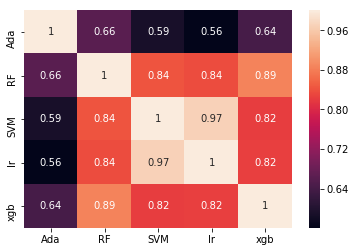

In [114]:
test_Survived_AdaC = pd.Series(ada_best.predict(X_test), name="Ada")
test_Survived_RFC = pd.Series(RFC_best.predict(X_test), name="RF")
test_Survived_SVMC = pd.Series(SVMC_best.predict(X_test), name="SVM")
test_Survived_lr= pd.Series(lr_best.predict(X_test), name="lr")
test_Survived_xgb = pd.Series(xgb_best.predict(X_test), name="xgb")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_AdaC,test_Survived_RFC,
                              test_Survived_SVMC,test_Survived_lr, 
                              test_Survived_xgb],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [115]:
scores = cross_val_score(estimator = ada_best,X = X_train,y=y_train,cv = kfold,scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(),scores.std(),'ada'))
scores = cross_val_score(estimator = RFC_best,X = X_train,y=y_train,cv = kfold,scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(),scores.std(),'RF'))
scores = cross_val_score(estimator = SVMC_best,X = X_train,y=y_train,cv = kfold,scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(),scores.std(),'SVM'))
scores = cross_val_score(estimator = lr_best,X = X_train,y=y_train,cv = kfold,scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(),scores.std(),'lr'))
scores = cross_val_score(estimator = xgb_best,X = X_train,y=y_train,cv = kfold,scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(),scores.std(),'xgb'))

Accuracy: 0.8093 (+/- 0.0443) [ada]
Accuracy: 0.8384 (+/- 0.0515) [RF]
Accuracy: 0.8328 (+/- 0.0417) [SVM]
Accuracy: 0.8317 (+/- 0.0387) [lr]
Accuracy: 0.8507 (+/- 0.0479) [xgb]


In [116]:
kfold_r = StratifiedKFold(n_splits=10,shuffle = True)
scores = cross_val_score(estimator = ada_best,X = X_train,y=y_train,cv = kfold_r,scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(),scores.std(),'ada'))
scores = cross_val_score(estimator = RFC_best,X = X_train,y=y_train,cv = kfold_r,scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(),scores.std(),'RF'))
scores = cross_val_score(estimator = SVMC_best,X = X_train,y=y_train,cv = kfold_r,scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(),scores.std(),'SVM'))
scores = cross_val_score(estimator = lr_best,X = X_train,y=y_train,cv = kfold_r,scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(),scores.std(),'lr'))
scores = cross_val_score(estimator = xgb_best,X = X_train,y=y_train,cv = kfold_r,scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(),scores.std(),'xgb'))

Accuracy: 0.8058 (+/- 0.0362) [ada]
Accuracy: 0.8395 (+/- 0.0351) [RF]
Accuracy: 0.8317 (+/- 0.0373) [SVM]
Accuracy: 0.8306 (+/- 0.0422) [lr]
Accuracy: 0.8473 (+/- 0.0146) [xgb]


In [134]:
voting1 = VotingClassifier(estimators=[('ada', ada_best), ('rf', RFC_best),
('svc', SVMC_best), ('lr',lr_best),('xgb',xgb_best)], voting='hard', n_jobs=-1)

scores = cross_val_score(estimator = voting1,X = X_train,y=y_train,cv = kfold_r,scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(),scores.std(),'5-voting'))


Accuracy: 0.8339 (+/- 0.0415) [5-voting]


In [133]:
voting2 = VotingClassifier(estimators=[('rf', RFC_best),
('svc', SVMC_best), ('lr',lr_best),('xgb',xgb_best)], voting='hard', n_jobs=-1)

scores = cross_val_score(estimator = voting2,X = X_train,y=y_train,cv = kfold_r,scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(),scores.std(),'4-voting'))


Accuracy: 0.8451 (+/- 0.0269) [4-voting]


In [130]:
voting3 = VotingClassifier(estimators=[('ada', ada_best), ('rf', RFC_best),
('svc', SVMC_best), ('lr',lr_best),('xgb',xgb_best)], voting='hard',
                           weights=[0,4,3,3,5],n_jobs=-1)

scores = cross_val_score(estimator = voting3,X = X_train,y=y_train,cv = kfold_r,scoring='accuracy')
print("Accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(),scores.std(),'5-voting(weight)'))


Accuracy: 0.8385 (+/- 0.0339) [5-voting(weight)]


In [120]:
voting1.fit(X_train, y_train)
y_test = voting1.predict(X_test)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": y_test
    })
submission.to_csv('titanic3_1a.csv',index = False)
voting1.score(X_train, y_train)

0.88776655443322106

In [121]:
voting2.fit(X_train, y_train)
y_test = voting2.predict(X_test)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": y_test
    })
submission.to_csv('titanic3_2a.csv',index = False)
voting2.score(X_train, y_train)

#final submission

0.86868686868686873

In [122]:
voting3.fit(X_train, y_train)
y_test = voting3.predict(X_test)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": y_test
    })
submission.to_csv('titanic3_3a.csv',index = False)
voting3.score(X_train, y_train)

0.88327721661054992

In [123]:
xgb_best.fit(X_train, y_train)
y_test = xgb_best.predict(X_test)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": y_test
    })
submission.to_csv('titanic3_4a.csv',index = False)
xgb_best.score(X_train, y_train)

0.88776655443322106